# Scratchpad to study training dynamics of Associative Memory model

The goal of this notebook is to understand the training dynamics of a simple associative memory models in terms of both the *edge of stability* phemenon and "memory erasing".

In [1]:
import subprocess
from math import sqrt
from random import seed

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

# be mindful of pseudo-random number generator
th.manual_seed(0)

Some of the code will be outsourced

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('.')

# Part 1: Setup and Training loop

## Model
We define the model.
We take random embeddings of both integer inputs $x$ and integer outputs $y$ as random vectors of the sphere in $\R^d$, respectively $e_x$ and $u_y$.
Then we map $x$ to $y$ through the model $y = f_W(x)$, where $W$ is a matrix of size $d \times d$ to be learned and that parameterizes
$$
    f_W(x) = \argmax_{y} e_x^\top W u_y = \argmax_y \langle e_x, W u_y \rangle.
$$
The natural formula would be
$
    f_W(x) = \argmax_{y} \langle u_y, W e_x \rangle,
$
but because of C memory order, it is more natural to implement it the other way around.

In [4]:
def get_embeddings(n, d, norm=True):
    emb = th.randn(n, d)
    if norm:
        emb /= emb.norm(dim=1, keepdim=True)
    else:
        emb /= sqrt(d)
    return emb


class AssMem(nn.Module):
    def __init__(self, E, U):
        """
        E: torch.Tensor
            Input embedding matrix of size $n \times d$,
            where $n$ is the number of tokens and $d$ is the embedding dimension.
        U: torch.Tensor
            Output unembedding matrix of size $d \times m$,
            where $m$ is the number of classes and $d$ is the embedding dimension.
        """
        super().__init__()
        d = E.shape[1]
        self.W = nn.Parameter(th.zeros(d, d))
        # self.W = nn.Parameter(th.randn(d, d) / sqrt(d))
        self.E = E
        self.UT = U.T

    def forward(self, x):
        """
        Compute the score :math:`g(x, y) = u_y^\top W e_x`.
        """
        emb = self.E[x]
        if emb.size(0) < self.UT.size(1):   # if b < m
            out = emb @ self.W      # (b, d) @ (d, d) -> (b, d)  in O(bd^2)
            out = out @ self.UT     # (b, d) @ (d, m) -> (b, m)  in O(bdm)
        else:
            out = self.W @ self.UT  # (d, d) @ (d, m) -> (d, m)  in O(md^2)
            out = emb @ out         # (b, d) @ (d, m) -> (b, m)  in O(bdm)
        return out

    def fit(self, x):
        """
        Compute the prediction :math:`f(x) = \operatorname{argmax}_y u_y^\top W e_x`.
        """
        score = self.forward(x)
        return score.argmax(dim=1)


## Data
Let's start with a small specification of the model.
Assume that the $y = x$ and the $x$ is taken uniformly at random over $n$ integers.
Later we could consider more complex model such as $y = f(x, \epsilon)$ where $\epsilon$ is a noise term, and $x$ to be non-uniform (which would reduce the "effective dimension").

In [5]:
# number of input tokens
n = 30

# probability of the inputs, a Zipf law of parameter alpha
alpha = 0                 # alpha = 0 means uniform distribution
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()

In [6]:
# association model
def f(x, epsilon=None):
    """
    Model of association between `x` and `y`.
    """
    return x

# noise level
epsilon = 0

# target associations
all_y = f(all_x, 0)

In [7]:
# memory dimension
d = 10

# random embeddings
E = get_embeddings(all_x.max() + 1, d, norm=False)
U = get_embeddings(all_y.max() + 1, d, norm=True)

# model
model = AssMem(E, U)

## Optimization procedure
We will learn the matrix $W$ by gradient descent on a surrogate loss function.
We use the softmax loss (which is convex in $W$)
$$
    \ell(W; x, y) = \log \left( \sum_{z} \exp \langle e_x, W u_z \rangle \right) - \langle e_x, W u_y \rangle.
$$
We begin with a constant step size $\eta$, and batch size equals one.
We begin with a constant step size $\eta$, and batch size equals one.
We could easily change the code to try out other optimization procedures.

In [8]:
# optimization parameter 
batch_size = 1
nb_epoch = 10000
T = nb_epoch * batch_size
lr = 1e0

optimizer = th.optim.SGD(model.parameters(), lr=lr, momentum=0)
# scheduler = th.optim.lr_scheduler.StepLR(optimizer, nb_epoch // 10, gamma=0.1)

In [9]:
# training loop 

train_loss = th.zeros(nb_epoch)
test_loss = th.zeros(nb_epoch)

for i in range(nb_epoch):
    # get batch of data
    x = th.multinomial(proba, batch_size, replacement=True)
    y = f(x, epsilon)

    # compute loss
    score = model(x)
    loss = F.cross_entropy(score, y)
    
    # record statistics
    train_loss[i] = loss.item()
    with th.no_grad():
        pred = model.fit(all_x)
        test_loss[i] = proba[pred != all_y].sum().item()

    # update parameters with gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()


## Visualization

We configure matplotlib to render nicely in a TeX file by notably compute the width of figures exactly (rather than resizing it in TeX).
You can find width of a LaTeX documents with \the\textwidth, and the font size with \expandafter\string\the\font
Here I assume that we use the `times` font with a size of 12pt, and a document of width 6.5in (or 472 pt).

In [10]:
width = 472 / 72

plt.rc('font', family='serif', size=8)
usetex = not subprocess.run(['which', 'pdflatex']).returncode
plt.rc('text', usetex=usetex)
if usetex:
    plt.rc('text.latex', preamble=r'\usepackage{times}')

/home/vivc/.local/share/texlive/2022/bin/x86_64-linux/pdflatex


To average out the noise in the training procedure, we can use an exponential moving average

In [11]:
@th.jit.script
def ewma(x: th.Tensor, theta: float):
    r = th.zeros_like(x)
    r[0] = x[0]
    for i in range(1, x.shape[0]):
        r[i] = theta * r[i - 1] + (1 - theta) * x[i]
    return r

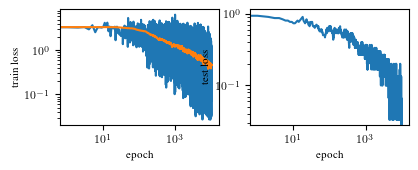

In [12]:
# # for TeX documents
# fig, ax = plt.subplots(1, 1, figsize=(.48 * width, .48 * width / 1.618))
# for visualization ease in this notebook
fig, axes = plt.subplots(1, 2, figsize=(4.5, 1.5))

axes[0].plot(th.arange(nb_epoch), train_loss, label='train')
smooth_train_loss = ewma(train_loss, .99)
axes[0].plot(th.arange(nb_epoch), smooth_train_loss, label='train')
axes[1].plot(th.arange(nb_epoch), test_loss, label='test')

for i in range(2):
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel('epoch')
    loss_type = {0: "train", 1: "test"}[i]
    axes[i].set_ylabel(f'{loss_type} loss')

fig.savefig('eos_first_plot.pdf', bbox_inches='tight', pad_inches=0)

# Part 2: Profiling the training to analyze it

## Training Dynamics Logging
In order to better understand the dynamics of the optimization, we will monitor quantities related to the gradient and the Hessian of the loss function.

#### Gradient computation
The gradient of the loss is easy to compute with simple derivations rules.
$$
    \nabla \ell(W; x, y) 
    = \nabla \log \left( \sum_{z} \exp \langle e_x, W u_z \rangle \right) - \nabla \langle e_x, W u_y \rangle
    = \sum_{z} \frac{\exp \langle e_x, W u_z \rangle}{\sum_{z'} \exp \langle e_x, W u_{z'} \rangle} e_x u_z^\top  - e_x u_y^\top.
$$
This gradient can be understood with the probabilistic perspective on the loss as
$$
    \nabla \ell(W; x, y) 
    = \sum_{z} p_W(z\,\vert\, x) e_x u_z^\top - e_x u_y^\top.
$$

#### Hessian computation
Notice that when the gradient can be written as
$$    
    \nabla \ell(\theta) = g(\theta) \cdot a = (\partial_i \ell(\theta))_{i}, \qquad\text{with}\qquad g(\theta) \in \R,\quad a \in \R^d,
$$
the Hessian follows as
$$
    \nabla^2 \ell(\theta) = (\partial_{ij}\ell(\theta)) = (\partial_i\partial_j \ell(\theta)) = (\partial_i g(\theta)\, a_j) = (\nabla g(\theta))\,a^\top.
$$
In our case, we want to use the Euclidean structure on the matrix space, which leads to
$$
    \nabla^2 \ell(W; x, y) = \sum_{z} \nabla p_W(z\,\vert\, x) (e_x \otimes u_z)^\top.
$$
To compute $\nabla p_W(z\,\vert\, x)$, notice that we could equally have expressed the loss gradient as
$$
    \nabla \ell(W; x, y) = -\nabla \log p_W(y\,\vert\,x) = -\frac{\nabla p_W(y\,\vert\,x)}{p_W(y\,\vert\, x)},
$$
from which we deduce that
$$
    \nabla p_W(z\,\vert\,x) 
    = - p_W(z\,\vert\, x) \nabla \ell(W; x, z)
    \notag
    = p_W(z\,\vert\, x)\left(e_x \otimes u_z - \sum_{z'} p_W(z'\,\vert\, x) e_x \otimes u_{z'} \right).
$$
Plugging this into the previous equation, we will have to deal with quantities such as
$$
    (e_x \otimes u_y) (e_x \otimes u_z)^\top = e_x \otimes u_y \otimes e_x \otimes u_z.
$$
Most people,me included, are not really familiar with tensor operations.
For those, the last operation can be understood from the fact that, when $f_i$ the canonical basis of $\R^d$, and $a$ and $b$ in $\R^d$, we have the matrix identification
$$
    (a b^\top)_{i,j} = \langle a, f_i \rangle \langle b, f_j \rangle  
$$
In our case, using $ij$ as the matrix indexation for $\R^{d\times d}$ and $f_i f_j^\top$ as the canonical basis of $\R^{d\times d}$,
$$
    \left((e_x \otimes u_y)(e_x\otimes u_z)^\top\right)_{ij, kl}
    =  \langle e_x \otimes u_y, f_i \otimes f_j \rangle \langle e_x\otimes u_z, f_k\otimes f_l \rangle  
    = (f_i^\top e_x)(f_j^\top u_y)(f_k^\top e_x)(f_i^\top u_z)
    = \langle f_i\otimes f_j\otimes f_k\otimes f_l\otimes, e_x\otimes u_y\otimes e_x\otimes u_z\rangle.
$$
Using the two previous equation, we deduce
$$
    \nabla^2 \ell(W; x, y) 
    = \sum_{z,z'} p_W(z\,\vert\, x) (\delta_{z,z'} - p_W(z'\,\vert\, x)) e_x\otimes u_z\otimes e_x\otimes u_{z'}.
$$
Let us implemented this formula vectorially, and check its correctness based on automatic differentiation libraries.

In [13]:
from scipy.linalg import eigh
from torch.autograd.functional import hessian
from model import AssociativeMemory

In [14]:
batch_size = 20
x = th.multinomial(proba, batch_size, replacement=True)
y = f(x, epsilon)
emb = E[x]
W = th.randn(d, d)

def loss_func(inp):
    logit = emb @ inp @ U.T
    log_likelihood = F.log_softmax(logit, dim=1)
    return - log_likelihood[th.arange(batch_size), y].mean()

# compute quantities with pytorch
hess = hessian(loss_func, W)

W.requires_grad=True
my_loss = loss_func(W)
grad = th.autograd.grad(my_loss, W)[0]

model.W.data = W
score = model(x)
loss = F.cross_entropy(score, y)
nn_grad = th.autograd.grad(loss, model.W)[0]

# compute quantities ourselves, start with the gradient
prob = F.softmax(score, dim=1)
prob[th.arange(batch_size), y] -= 1
my_grad = emb.T @ prob @ U
my_grad /= batch_size

# Hessian computation: the code has been outsourced to `model.py`

model = AssociativeMemory(E, U)
model.W.data = W
my_hessian = model.hessian(x)

# check correctness
assert (loss - my_loss) < 1e-7
assert (grad == nn_grad).all()
assert (grad - my_grad).abs().max().item() < 1e-7
assert (my_hessian - hess.view(d*d, d*d)).abs().max() < 1e-7

# check PSD
assert (th.linalg.eigvals(my_hessian).real > 0).all()

To compute the eigenvalues, it is better to use Lapack-based implementations that are not in pytorch at the moment.

In [15]:

top_eigenvalues = eigh(my_hessian.numpy(), eigvals_only=True, subset_by_index=[d*d-10, d*d-1])

## Training loop with Hessian profiling

Let us track the $k$ biggest eigenvalues of the Hessian.

In [16]:
# hyparameters
n = 30
alpha = 0
epsilon = 0
d = 10

batch_size = 1
nb_epoch = 10000
T = nb_epoch * batch_size
lr = 1e0

# data
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = f(all_x, epsilon)

# model
E = get_embeddings(all_x.max() + 1, d, norm=False)
U = get_embeddings(all_y.max() + 1, d, norm=True)
model = AssociativeMemory(E, U)
optimizer = th.optim.SGD(model.parameters(), lr=lr, momentum=0)

In [17]:
# training loop 
k = 10

train_loss = th.zeros(nb_epoch)
test_loss = th.zeros(nb_epoch)
eigenvals = np.zeros((nb_epoch, k))

for i in range(nb_epoch):
    # get batch of data
    x = th.multinomial(proba, batch_size, replacement=True)
    y = f(x, epsilon)

    # compute loss
    score = model(x)
    loss = F.cross_entropy(score, y)
    
    # record statistics
    train_loss[i] = loss.item()
    with th.no_grad():
        pred = model.fit(all_x)
        test_loss[i] = proba[pred != all_y].sum().item()

    # Hessian statistics
    hessian = model.hessian(all_x, proba)
    eigenvals[i] = eigh(hessian.numpy(), eigvals_only=True, subset_by_index=[d*d-k, d*d-1])

    # update parameters with gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()


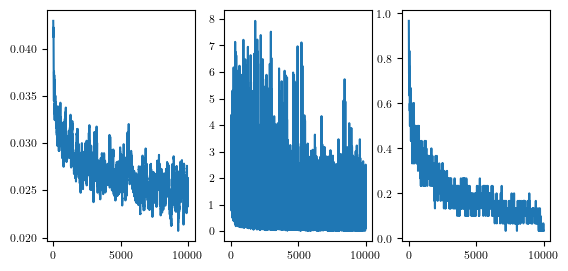

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(6.5, 3))
axes[0].plot(np.arange(nb_epoch), eigenvals[:, -1])
axes[1].plot(th.arange(nb_epoch), train_loss)
axes[2].plot(th.arange(nb_epoch), test_loss)

## Landscape visualization

Our simple setting is convex, we can picture it mentally as a bowl.
We can plot this bowl with its level line, and better understand what the oscillation means.

We will plot four different lanscape:
- the population training landscape $W \to {\cal L}(W) = \mathbb{E}_{x,y}[\ell(W; x, y)]$.
- the individual landscape $W\to \ell(W; x, y)$.
- the testing landscape $W \to {\cal L}_{01}(W) = \mathbb{E}_{x,y}[1_{f_W(x) \neq y}]$.
- the indiviual testing landscape $W \to {\cal L}_{01}(W) = 1_{f_W(x) \neq y}$.

To be able to plot it in 2d, we will consider $d=2$ and $W = \operatorname{diag}(w_i)$.

In [28]:
d = 2
n = 5
alpha = 1

all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba[n//2:] = .1
proba /= proba.sum()

all_y = f(all_x, 0)

th.manual_seed(0)
E = get_embeddings(all_x.max() + 1, d, norm=False)
U = get_embeddings(all_y.max() + 1, d, norm=True)
E[0, 0] = U[0, 0] = 1
E[0, 1] = U[0, 1] = 0
E[1, 0] = U[1, 0] #= 0
E[1, 1] = U[1, 1] #= 1
E[2, 0] = U[2, 0] #= 1/sqrt(2)
E[2, 1] = U[2, 1] #= 1/sqrt(2)
E[3, 0] = U[3, 0] #= -1/sqrt(2)
E[3, 1] = U[3, 1] #= 1/sqrt(2)
E[4, 0] = U[4, 0] #= -1/sqrt(2)
E[4, 1] = U[4, 1] #= -1/sqrt(2)

model = AssociativeMemory(E, U)

In [49]:
xlim = 10
num = 50
X, Y = np.meshgrid(np.linspace(-xlim, xlim, num=num), np.linspace(-xlim, xlim, num=num))

Ws = np.zeros((num * num, d, d))
Ws[:, 0, 0] = X.flatten()
Ws[:, 1, 1] = Y.flatten()
Ws = th.tensor(Ws, dtype=th.float32)

score = E @ (Ws @ U.T)

In [50]:
H = np.zeros((num**2, n))
for i in range(num**2):
    model.W.data = Ws[i]
    for j in range(n):
        H[i, j] = eigh(model.hessian(all_x[j:j+1]).numpy(), eigvals_only=True).max()


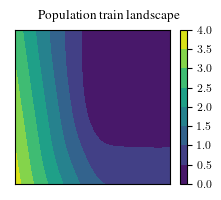

In [51]:
log_likelihood = F.log_softmax(score, dim=2)
log_likelihood = log_likelihood[:, th.arange(n), all_y]
train_loss = (log_likelihood * (-proba)).mean(dim=1)
Z = train_loss.numpy()
fig, ax = plt.subplots(figsize=(2.5, 2))
c = ax.contourf(X, Y, Z.reshape(num, num))
fig.colorbar(c)
ax.set_xticks([])
ax.set_yticks([])
fig.suptitle('Population train landscape')
fig.savefig('population_train_landscape.pdf', bbox_inches='tight', pad_inches=0)

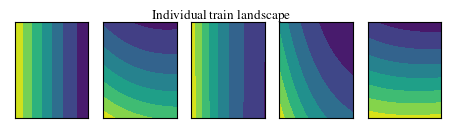

In [48]:
fig, ax = plt.subplots(1, 5, figsize=(5.5, 1.25))
for i in range(5):
    ax[i].contourf(X, Y, -log_likelihood[:, i].reshape((num, num)))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.suptitle('Individual train landscape')
fig.savefig('individual_train_landscape.pdf', bbox_inches='tight', pad_inches=0)

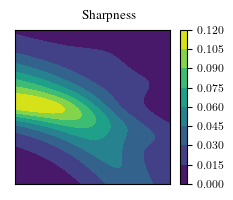

In [24]:
Z = (H * proba.numpy()).mean(axis=1)
fig, ax = plt.subplots(figsize=(2.5, 2))
c = ax.contourf(X, Y, Z.reshape(num, num))
fig.colorbar(c)
ax.set_xticks([])
ax.set_yticks([])
fig.suptitle('Sharpness')
fig.savefig('sharpness.pdf', bbox_inches='tight', pad_inches=0)

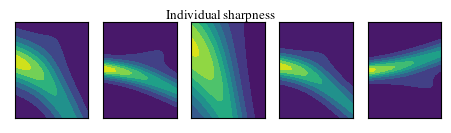

In [25]:
fig, ax = plt.subplots(1, 5, figsize=(5.5, 1.25))
for i in range(5):
    ax[i].contourf(X, Y, H[:, i].reshape((num, num)))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.suptitle('Individual sharpness')
fig.savefig('individual_sharpness.pdf', bbox_inches='tight', pad_inches=0)

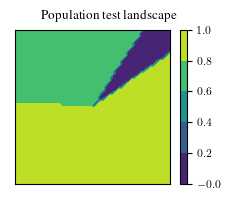

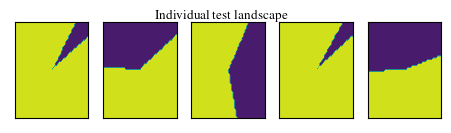

In [26]:
pred = score.argmax(dim=2)
pred = (pred != all_y).to(float)

fig, ax = plt.subplots(figsize=(2.5, 2))
c = ax.contourf(X, Y, (pred * proba).sum(dim=1).reshape((num, num)), levels=[-.0001, .2, .4, .6, .8, 1.00001])
fig.colorbar(c)
ax.set_xticks([])
ax.set_yticks([])
fig.suptitle('Population test landscape')
fig.savefig('population_test_landscape.pdf', bbox_inches='tight', pad_inches=0)

fig, ax = plt.subplots(1, 5, figsize=(5.5, 1.25))
for i in range(5):
    ax[i].contourf(X, Y, pred[:, i].reshape((num, num)))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.suptitle('Individual test landscape')
fig.savefig('individual_test_landscape.pdf', bbox_inches='tight', pad_inches=0)